### Collab Related Only

- Connecting to Google Drive;
- Installing missing packages in the current kernel;

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')
root = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [2]:
# Installing missing pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 4.8 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=03b0fa48b05fbf55637bdaf9a69dac27f949dc125a1803d90ac7918a17fcd259
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


### Setup
This notebook processes given midi files, extracts notes, trains an RNN and generates new music for a provided piece.  
We would need the following libraries to get started.

In [34]:
import collections
import glob
import pretty_midi
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow.keras import layers, losses, optimizers, callbacks, Input, Model
from tensorboard.plugins.hparams import api as hp

print(tf. __version__)
CHECKPOINTS_PATH = root + 'CM3070/checkpoints_v3/'

2.8.2


### Data

Loading data and defining data related functions.

In [4]:
midi_files = glob.glob(str(root + 'CM3070/data/*.mid*'))
print('Number of files loaded:', len(midi_files))

def midi_to_notes(midi_file):
    instrument_notes = []

    pm = pretty_midi.PrettyMIDI(midi_file)
    # Some guitar tracks use different midi instruments (i.e. clean/overdrive)
    for instrument in pm.instruments:
        last_instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
        instrument_notes += instrument.notes
    
    # Sort the notes by start time
    sorted_notes = sorted(instrument_notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    # Process features
    processed_notes = collections.defaultdict(list)
    for note in sorted_notes:
        processed_notes['pitch'].append(note.pitch)
        processed_notes['start'].append(note.start)
        processed_notes['end'].append(note.end)
        processed_notes['step'].append(note.start - prev_start)
        processed_notes['duration'].append(note.end - note.start)
        prev_start = note.start

    return pd.DataFrame({
        name: np.array(value) for name, value in processed_notes.items()
    })

def notes_to_midi(notes, out_file, instrument_name, velocity = 100):
    # Create an instrument
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    # Map given notes to the expected schema
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    # Create a file, append the instrument and write it to a disk
    pm = pretty_midi.PrettyMIDI()
    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

Number of files loaded: 150


Define plot functions for note distribution and piano roll.

In [12]:
def plot_piano_roll(notes, num_of_notes=0):
    if num_of_notes:
        title = f'First {num_of_notes} notes'
    else:
        title = f'Whole track'
        num_of_notes = len(notes['pitch'])
    # Plotting the roll
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :num_of_notes], plot_pitch[:, :num_of_notes], color="r", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    plt.title(title)

def plot_distributions(notes, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    # Plotting pitch
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)
    # Plotting step
    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
    # Plotting duration
    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

### Create the training dataset

In [56]:
# set how many files use for training here
num_files = len(midi_files)

# set the key order
key_order = ['pitch', 'step', 'duration']

track_notes_sets = []
for file in midi_files[:num_files]:
    notes = midi_to_notes(file)
    train_notes = np.stack([notes[key] for key in key_order], axis=1)
    track_notes_set = tf.data.Dataset.from_tensor_slices(train_notes)
    track_notes_sets.append(track_notes_set)

all_notes_count = sum([len(track_notes_set) for track_notes_set in track_notes_sets])
print('Number of tracks parsed:', len(track_notes_sets))
print('Number of total notes parsed:', all_notes_count)

Number of tracks parsed: 150
Number of total notes parsed: 262810


We will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and next note as the label. This way, the model will be trained to predict the next note in a sequence.

In [29]:
# Returns tensorflow dataset of sequences and label examples.
def create_sequences(datasets, sequence_length):
    # Normalize note pitch
    def scale_pitch(x):
        # The size of the vocabulary is set to 128 by default, representing all the pitches supported by pretty_midi
        vocab_size = 128
        x = x / [vocab_size, 1.0, 1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels = {
            key: sequences[-1][i] for i, key in enumerate(key_order)
        }
        return scale_pitch(inputs), labels

    # Take 1 extra note for the labels
    sequence_length += 1
    
    for i, dataset in enumerate(datasets):
        batches = dataset.window(sequence_length, shift=1, stride=1, drop_remainder=True)
        # Flatten into a dataset of tensors
        tensors = batches.flat_map(lambda window: window.batch(sequence_length, drop_remainder=True))
        mapped_tensors = tensors.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
        if i == 0:
            result = mapped_tensors
        else:
            result = result.concatenate(mapped_tensors)
    return result

# Returns batched and shuffled dataset
def create_train_ds(sequence_length):
    sequences_ds = create_sequences(track_notes_sets, sequence_length)

    for seq, target in sequences_ds.take(1):
        print('sequence shape:', seq.shape)
        print('sequence elements (first 5):', seq[0:5])
        print('target:', target)

    batch_size = 64
    # The number of items in the dataset
    buffer_size = all_notes_count - sequence_length  
    train_ds = (sequences_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))
    return train_ds

### Create and train the model

The model will have three outputs, one for each note variable.

For step and duration, we will use a custom loss function based on MSE that encourages the model to output non-negative values.

In [38]:
# Encourage non-negative values
def mse_with_positive_pressure(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

# Encourage longer steps and non-negative values
def mse_with_positive_step_pressure(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    longer_positive_step_pressure = 10 * tf.maximum(0.05 - y_pred, 0.0)
    return tf.reduce_mean(mse + longer_positive_step_pressure)

In [40]:
# Model constructor
def create_model(hparams):
    sequence_length = hparams[HP_SEQ_LENGTH]
    input_shape = (sequence_length, 3)
    inputs = Input(input_shape)
    x = layers.LSTM(hparams[HP_NUM_UNITS], kernel_regularizer='l2')(inputs)

    # Initiate layers
    network = Model(
        inputs, 
        {
            'pitch': layers.Dense(128, name='pitch')(x),
            'step': layers.Dense(1, name='step')(x),
            'duration': layers.Dense(1, name='duration')(x),
        }
    )

    # Compile
    learning_rate = hparams[HP_L_RATE]
    network.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'pitch': losses.SparseCategoricalCrossentropy(from_logits=True),
            'step': mse_with_positive_step_pressure,
            'duration': mse_with_positive_pressure,
        },
        # These weights are needed due to pitch loss being significantly greater than other losses
        loss_weights={
            'pitch': 0.05,
            'step': 1.0,
            'duration': 0.5,
        }
    )

    network.summary()
    return network

### Train the model

In [ ]:
# Model HParams
HP_SEQ_LENGTH = hp.HParam('sequence_length', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512]))
HP_L_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.0005]))

# Logging events for hparams
log_dir = root + 'CM3070/logs/hparam_tuning'
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[HP_SEQ_LENGTH, HP_NUM_UNITS, HP_L_RATE],
        metrics=[hp.Metric('loss', display_name='Loss')],
    )

# Iterate over hparams and train
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for learning_rate in HP_L_RATE.domain.values:
        for seq_length in HP_SEQ_LENGTH.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_L_RATE: learning_rate,
                HP_SEQ_LENGTH: seq_length,
            }

            run_name = "run-%d" % session_num
            print('--- Starting trial: %s ----' % run_name)
            print({h.name: hparams[h] for h in hparams})

            network_callbacks = [
                hp.KerasCallback(log_dir + '/' + run_name, hparams),  # logs hparams
                callbacks.ModelCheckpoint(
                    filepath=CHECKPOINTS_PATH + str(num_units) + '_' + str(seq_length) + '_' + str(learning_rate) + '_' + run_name + '/cp-{epoch}.h5',
                    monitor='loss',
                    save_best_only=True
                ), # saves best models
                callbacks.EarlyStopping(
                    monitor='loss',
                    patience=50,
                    verbose=1,
                    restore_best_weights=True
                ) # stopes training when diverging for 50 epochs
            ]

            # Create note sequences
            train_ds = create_train_ds(seq_length)
            # Create a new model with current parameters
            network = create_model(hparams)

            # Max number of epochs
            epochs = 1000

            # Save last trained model's history
            history = network.fit(train_ds, epochs=epochs, callbacks=network_callbacks)
            session_num += 1

### Load model. Optional.
Here we are loding the best model based of the gathered logs and tuning. The model's checkpoint is required.

In [8]:
network = tf.keras.models.load_model(
    CHECKPOINTS_PATH + '256_32_0.0005_run-1/cp-549.h5',
    custom_objects={
        'mse_with_positive_step_pressure': mse_with_positive_step_pressure,
        'mse_with_positive_pressure': mse_with_positive_pressure
})

### Generate notes

To use the model to generate notes, we will first need to provide a starting sequence of notes (input midi).

For note pitch, it draws a sample from softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated.

In [16]:
sequence_length = 32

def predict_next_note(notes, model, temperature=1.0):
    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(inputs)

    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)

    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # Make sure step and duration values non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

temperature = 3.35
num_predictions = 150

test_files = glob.glob(str(root + 'CM3070/test/*.mid*'))
test_notes = midi_to_notes(test_files[0])
sample_notes = np.stack([test_notes[key] for key in key_order], axis=1)
# Pitch is normalized similar to training sequences
input_notes = (sample_notes[:sequence_length] / np.array([128, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, network, temperature)
    start = prev_start + step
    end = start + duration
    # TODO: This model messed the key pitch for some reason
    # if pitch == 79:
    #     pitch = 48
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

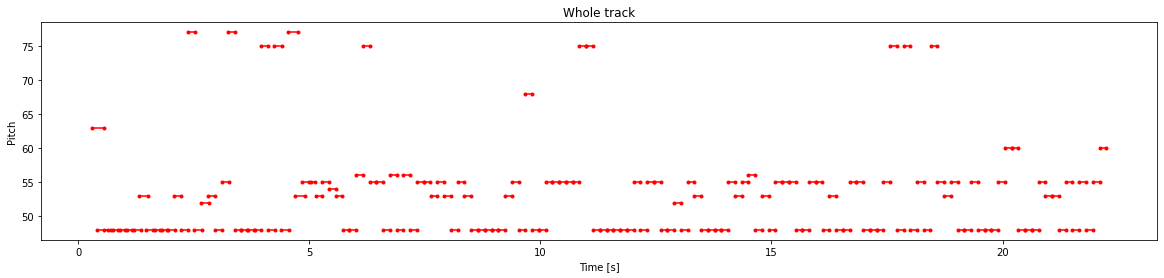

In [17]:
generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))
plot_piano_roll(generated_notes)

In [113]:
current_time = datetime.now().strftime("%H:%M:%S")
instrument_name = 'Distortion Guitar'
# Save the midi
!mkdir output
notes_combined = pd.concat([test_notes, generated_notes])
notes_to_midi(generated_notes, out_file='/content/output/' + current_time + '.mid', instrument_name=instrument_name)
notes_to_midi(notes_combined, out_file='content/output/combined_' + current_time + '.mid', instrument_name=instrument_name)

mkdir: cannot create directory ‘output’: File exists
